# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (D - A) \qquad \text{and} \qquad c = D^{-1} b
$$

Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [2]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [3]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [4]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [5]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [6]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [7]:
def jacobi_iter(A, b, n):
    diag = np.diag(A)
    B = np.diag(1. / diag) @ (np.diag(diag) - A)
    c = np.diag(1. / diag) @ b
    x = np.ones(b.shape)
    for i in range(n):
        x = B @ x + c
    return x, np.linalg.norm(B)

Убедимся, что все работает

In [8]:
n1 = 8
A1 = rndm.uniform(size=(n1, n1)) + np.diagflat([15]*n1)
b1 = rndm.uniform(size=n1)

In [9]:
x1, norm1 = jacobi_iter(A1, b1, 30)

print('Норма матицы B равна {}\n'.format(norm1))
print(A1 @ x1 - b1)

Норма матицы B равна 0.29417978724692306

[ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16 -1.11022302e-16  0.00000000e+00]


Как видно, в случае, когда матрица $A_1$ диагонально доминирующая, алгоритм хорошо сходится к правильному решению. Теперь заменим диагональные элементы маттрицы на её минимальный элемент

In [10]:
np.fill_diagonal(A1, A1.min())

x1_1, norm1_1= jacobi_iter(A1, b1, 30)

print('Норма матицы B равна {}\n'.format(norm1_1))
print(A1 @ x1_1 - b1)

Норма матицы B равна 492.00142565985897

[1.90466166e+78 2.52675686e+78 2.12003664e+78 1.94302934e+78
 1.83504824e+78 2.75968872e+78 2.89982295e+78 2.44239878e+78]


В этом случае $\| B\| \gg 1$, и, как следствие, алгоритм не сходится к правильному ответу

Теперь разберемся, как в общем случае сходимость алгоритма зависит от размерности задачи и от диагональных элементов матрицы при прочих равных параметрах. Сначала посмотрим на зависимость от величины матрицы 

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


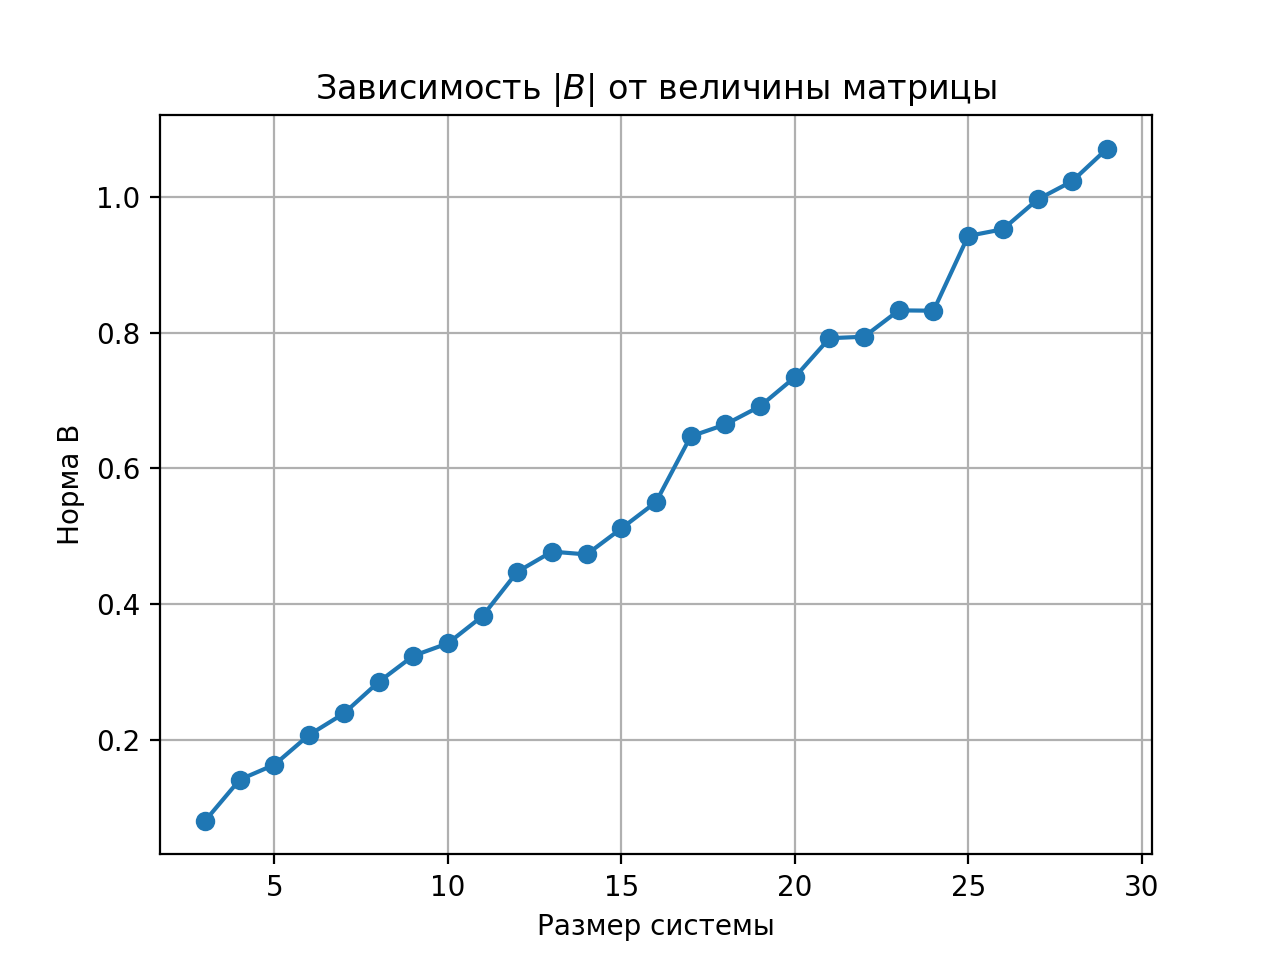

<IPython.core.display.Javascript object>


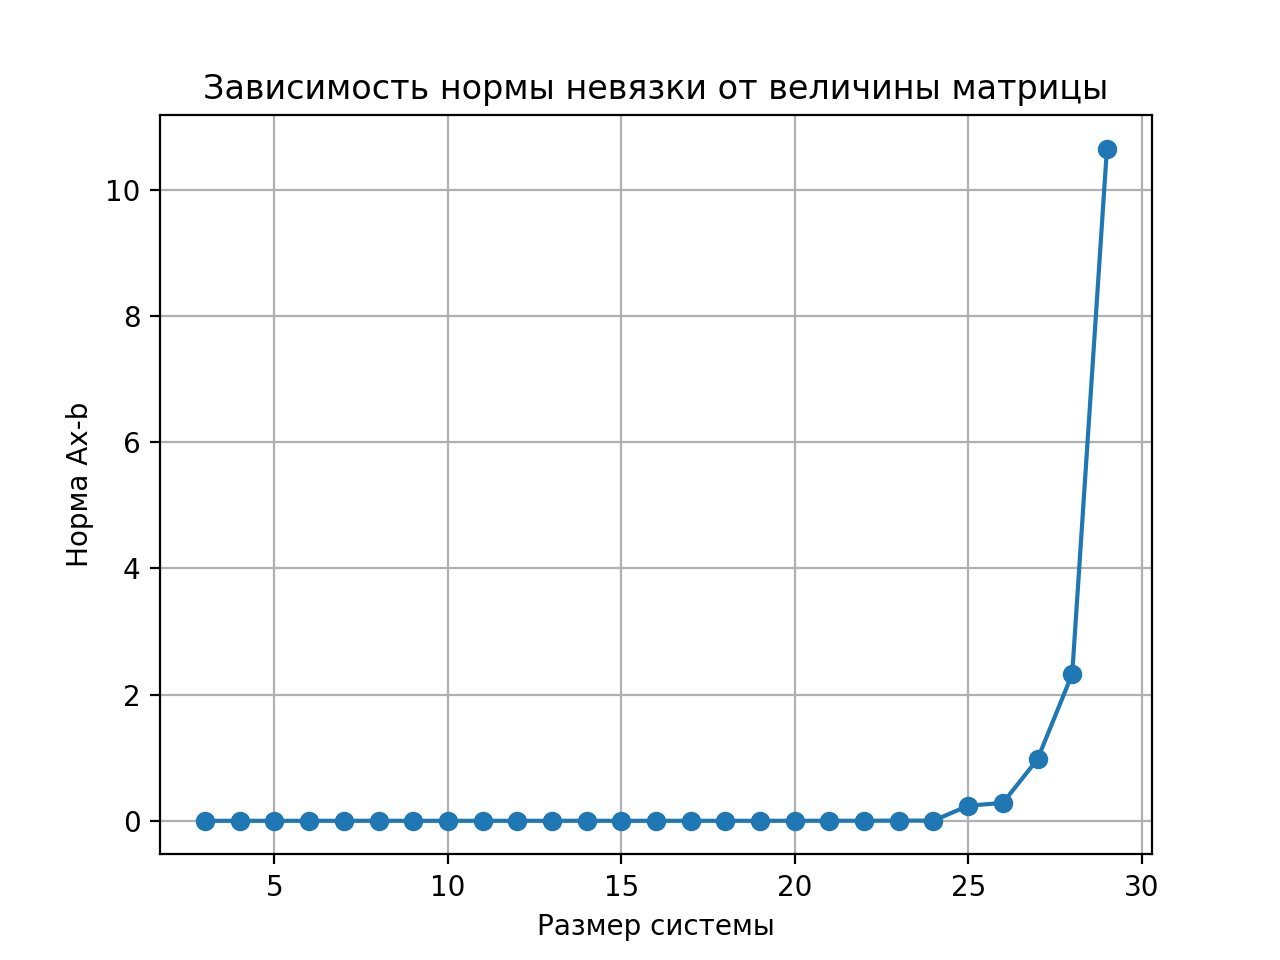

In [12]:
normB1 = []
normRes1 = []
N = [i for i in range(3, 30)]
for i in range(3, 30):
    A2 = rndm.uniform(size=(i, i)) + np.diagflat([15]*i)
    b2 = rndm.uniform(size=i)
    x2, norm2 = jacobi_iter(A2, b2, 30)
    normB1.append(np.linalg.norm(norm2))
    normRes1.append(np.linalg.norm(A2 @ x2 - b2))
    
plt.figure()
plt.plot(N, normB1, 'o-')
plt.grid()
plt.xlabel('Размер системы')
plt.ylabel('Норма B')
plt.title('Зависимость $\|B\|$ от величины матрицы')

plt.figure()
plt.plot(N, normRes1, 'o-')
plt.grid()
plt.xlabel('Размер системы')
plt.ylabel('Норма Ax-b')
plt.title('Зависимость нормы невязки от величины матрицы')

plt.show()

Из графиков можно сделать вывод, что при размере матрицы $A$ больше $27\times 27$ добавки 15 к диагонали недостаточно для того, чтобы алгоритм сходился. А при размерности от $25\times 25$ $\|B\|$ становится близка к единице, и поэтому алгоритму недостаточно 30 итераций, чтобы найти точное решение уравнения

Теперь посмотрим на зависимость сходимости от диагональных элементов матрицы $A$

<IPython.core.display.Javascript object>


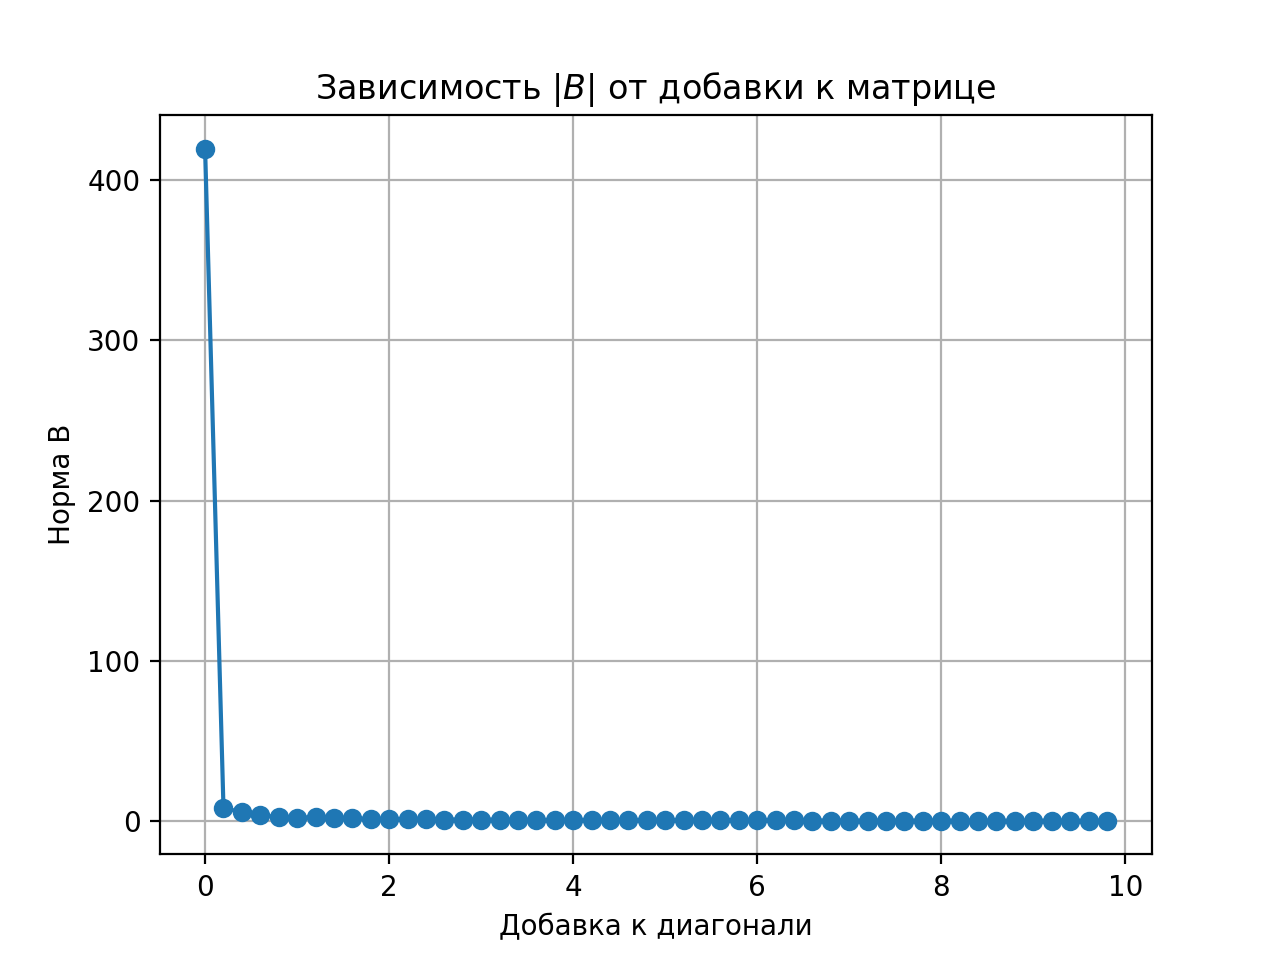

<IPython.core.display.Javascript object>


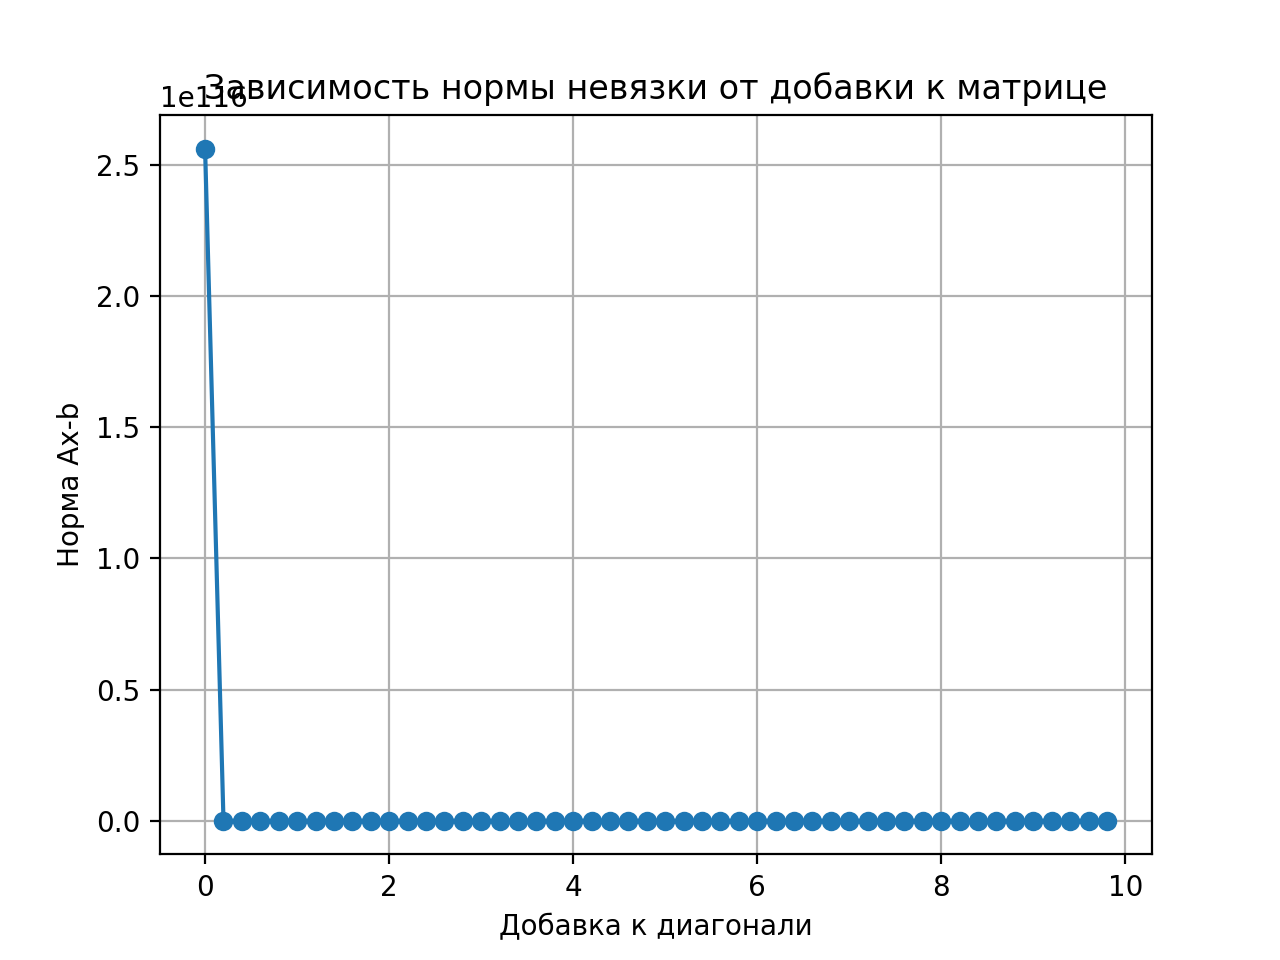

In [13]:
normB2 = []
normRes2 = []
ad = []
for i in range(50):
    A3 = rndm.uniform(size=(7, 7)) + np.diagflat([i / 5]*7)
    b3 = rndm.uniform(size=7)
    x3, norm3 = jacobi_iter(A3, b3, 80)
    normB2.append(np.linalg.norm(norm3))
    normRes2.append(np.linalg.norm(A3 @ x3 - b3))
    ad.append(i / 5)

plt.figure()
plt.plot(ad, normB2, 'o-')
plt.grid()
plt.xlabel('Добавка к диагонали')
plt.ylabel('Норма B')
plt.title('Зависимость $\|B\|$ от добавки к матрице')

plt.figure()
plt.plot(ad, normRes2, 'o-')
plt.grid()
plt.xlabel('Добавка к диагонали')
plt.ylabel('Норма Ax-b')
plt.title('Зависимость нормы невязки от добавки к матрице')

plt.show()

Здесь возникает следующая проблема: при очень маленьких добавках к матрице $\|B\|$ получается настолько большой, что алгоритм очень сильно расходится. И поэтому нельзя уместить на одном графике норму невязки для маленькой добавки и для большой. Поэтому я не вижу лучше способа, чем вывести все $\|Ax-b\|$ и рассмотреть их самостоятельно

In [14]:
t = len(normRes2)
for i in range(t):
    print('Добавка: {}, норма B: {}, норма Ax-b: {}'.format(i / 5, normB2[i], normRes2[i]))

Добавка: 0.0, норма B: 419.5959187792984, норма Ax-b: 2.5600359402195277e+116
Добавка: 0.2, норма B: 8.112399653180855, норма Ax-b: 3.911721135742517e+60
Добавка: 0.4, норма B: 5.875310024325026, норма Ax-b: 6.160367535376023e+53
Добавка: 0.6, норма B: 4.014957946557109, норма Ax-b: 1.9202928877929668e+39
Добавка: 0.8, норма B: 2.4722223172241353, норма Ax-b: 1.2753142766128374e+24
Добавка: 1.0, норма B: 2.397647567360177, норма Ax-b: 9.086096586887511e+21
Добавка: 1.2, норма B: 2.481627131838347, норма Ax-b: 7.284380607050365e+25
Добавка: 1.4, норма B: 2.337841196372924, норма Ax-b: 3.6474668539607513e+22
Добавка: 1.6, норма B: 1.9520870234634091, норма Ax-b: 4695322581987380.0
Добавка: 1.8, норма B: 1.4266082033572054, норма Ax-b: 5184.511331641402
Добавка: 2.0, норма B: 1.6207387203352268, норма Ax-b: 2127284167.9981534
Добавка: 2.2, норма B: 1.3163942089612226, норма Ax-b: 38.418159006246746
Добавка: 2.4, норма B: 1.2771567476913903, норма Ax-b: 120.453824328267
Добавка: 2.6, норма

Как и в прошлом тесте получаем, что алгоритм начинает сходиться только при $\|B\|<1$

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

$$Ax=b$$
$$A=L+D+U$$
$$\Rightarrow x^{(k+1)}=-(L+D)^{-1}\cdot U\cdot x^{(k)}+(L+D)^{-1}\cdot b$$
$$B=-(L+D)^{-1}\cdot U \qquad \text{and} \qquad c=(L+D)^{-1}\cdot b$$

Сначала напишем функцию, которая будет считать $(L+D)^{-1}$, то есть функцию, которая находит обратную матрицу к нижнетреугольной матрице*

*необходимо, чтобы на главной диагонале у первоначальной матрицы не было нулей

In [15]:
def inverse(A):
    n = A.shape[0]
    inv = np.diag(1 / np.diag(A))
    e = inv @ A
    for i in range(n - 1):
        k = np.eye(n)
        k[i+1:,i] = -e[i+1:,i]
        e = k @ e
        inv = k @ inv
    return inv

Теперь сам метод Зейделя:

In [16]:
def seidel_iter(A, b, t):
    n = b.shape[0]
    x = np.ones_like(b)
    U = np.zeros_like(A)
    LD = np.zeros_like(A)
    for i in range(n):
        U[:i,i] = A[:i,i]
        LD[i:,i] = A[i:,i]
    LD_inv = inverse(LD)
    B = - LD_inv @ U
    c = LD_inv @ b
    for i in range(t):
        x = B @ x + c
    return x, np.linalg.norm(B)

Снова убедимся, что все работает

In [17]:
n4 = 10
A4 = rndm.uniform(size=(n4, n4)) + np.diagflat([15]*n4)
b4 = rndm.uniform(size=n4)

x4, norm4 = seidel_iter(A4, b4, 20)

print('Норма матрицы B равна {}'.format(norm4))
print(A4 @ x4 - b4)

Норма матрицы B равна 0.25913583766521364
[ 0.00000000e+00  1.11022302e-16 -1.11022302e-16  0.00000000e+00
  1.11022302e-16  1.38777878e-17  0.00000000e+00 -1.11022302e-16
  1.11022302e-16  0.00000000e+00]


Теперь проведём тесты как в прошлом пункте

<IPython.core.display.Javascript object>


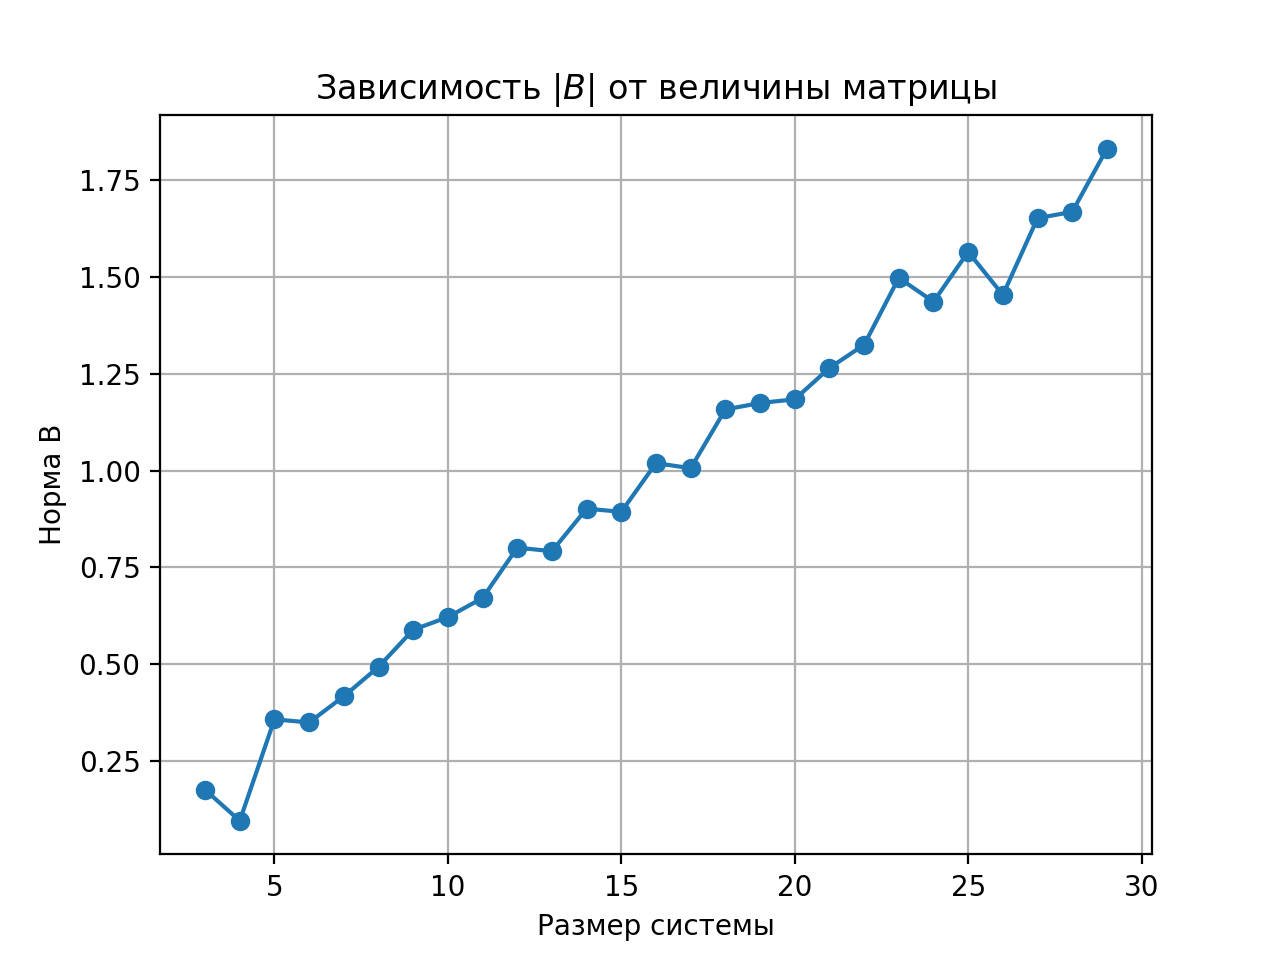

<IPython.core.display.Javascript object>


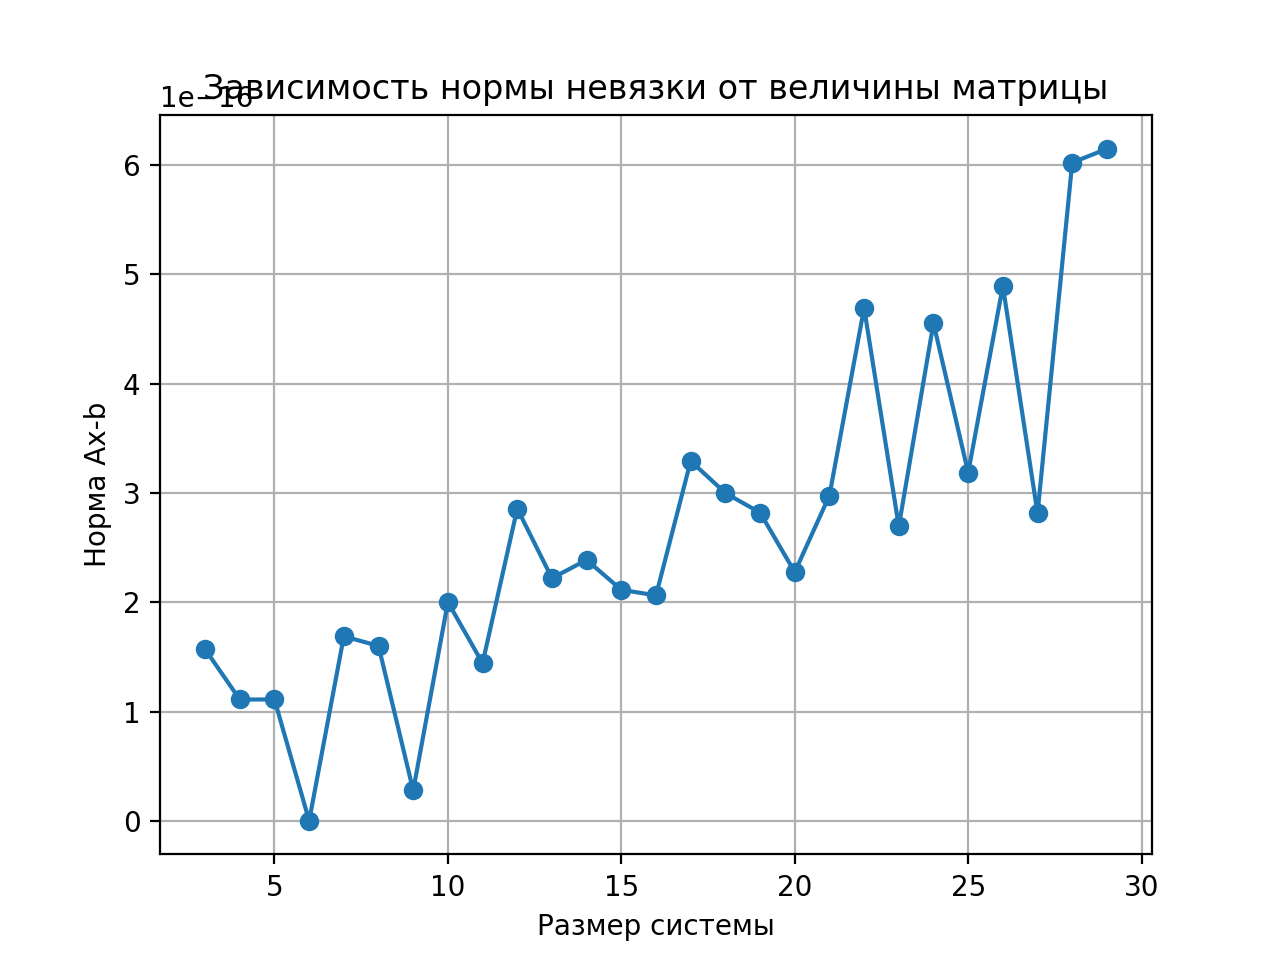

In [18]:
normB3 = []
normRes3 = []
N = [i for i in range(3, 30)]
for i in range(3, 30):
    A5 = rndm.uniform(size=(i, i)) + np.diagflat([5]*i)
    b5 = rndm.uniform(size=i)
    x5, norm5 = seidel_iter(A5, b5, 80)
    normB3.append(np.linalg.norm(norm5))
    normRes3.append(np.linalg.norm(A5 @ x5 - b5))
    
plt.figure()
plt.plot(N, normB3, 'o-')
plt.grid()
plt.xlabel('Размер системы')
plt.ylabel('Норма B')
plt.title('Зависимость $\|B\|$ от величины матрицы')

plt.figure()
plt.plot(N, normRes3, 'o-')
plt.grid()
plt.xlabel('Размер системы')
plt.ylabel('Норма Ax-b')
plt.title('Зависимость нормы невязки от величины матрицы')

plt.show()

In [19]:
for i in range(50):
    A6 = rndm.uniform(size=(7, 7)) + np.diagflat([i / 5]*7)
    b6 = rndm.uniform(size=7)
    x6, norm6 = jacobi_iter(A6, b6, 80)
    print('Добавка: {}, норма B: {}, норма Ax-b: {}'.format(i / 5,
                                                            np.linalg.norm(norm6),
                                                            np.linalg.norm(A6@x6-b6)))

Добавка: 0.0, норма B: 46.16591217495089, норма Ax-b: 2.9858754745991373e+100
Добавка: 0.2, норма B: 10.3228667717079, норма Ax-b: 6.029719035373283e+68
Добавка: 0.4, норма B: 6.315502341404637, норма Ax-b: 6.345092070446851e+50
Добавка: 0.6, норма B: 3.441693861897128, норма Ax-b: 5.7171687266036185e+31
Добавка: 0.8, норма B: 3.212027579260389, норма Ax-b: 4.095963347157371e+32
Добавка: 1.0, норма B: 2.8561025221595644, норма Ax-b: 3.0785283202468137e+27
Добавка: 1.2, норма B: 2.392595702470652, норма Ax-b: 3.155616547359855e+23
Добавка: 1.4, норма B: 2.2027598058530122, норма Ax-b: 1.9951277387659189e+21
Добавка: 1.6, норма B: 1.5405933080863798, норма Ax-b: 75549.11194512842
Добавка: 1.8, норма B: 1.8420760423568612, норма Ax-b: 193341942440974.16
Добавка: 2.0, норма B: 1.6642903332373709, норма Ax-b: 446066370599.79895
Добавка: 2.2, норма B: 1.5344494072739578, норма Ax-b: 35027888.93581892
Добавка: 2.4, норма B: 1.352469948026271, норма Ax-b: 225.60934066234194
Добавка: 2.6, норма

Снова получаем, что для сходимости должно выполняться $\|B\|<1$

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

Как выглядит алгоритм:
$$r_n=A x_n - b$$

$$\tau_{n+1} = \frac{(A r_n, r_n)}{\| A r_n\|^2}$$

$$x_{n+1}=x_n-\tau_{n+1}r_n$$

In [25]:
def min_res(A, b, n):
    xreal = np.linalg.solve(A, b)
    x = np.ones_like(b)
    Res = []
    delta = []
    Tau = []
    for i in range(n):
        delta.append(np.linalg.norm(x - xreal))
        r = A @ x - b
        Res.append(np.linalg.norm(r))
        tau = np.dot(A @ r, r) / np.dot(A @ r, A @ r)
        Tau.append(tau)
        x = x - tau * r
    iter = np.arange(1, n+1)
    
    
    plt.figure()
    plt.plot(iter, delta, '-', color='red', lw=1, label='$\|x_n-\widetilde{x}\|$')
    plt.plot(iter, Res, '-', color='blue', lw=1, label='$\|r_n\|$')
    plt.legend()
    plt.grid()
    plt.xlabel('Номер итерации')
    plt.ylabel('Нормы векторов')
    plt.title('Изменение невязки и отклонения от реального \nзначения корня в ходе работы алгоритма')
    
    
    plt.figure()
    plt.plot(iter, Tau, 'o-', lw=2)
    plt.grid()
    plt.xlabel('Номер итерации')
    plt.ylabel('tau') 
    plt.title('Изменение параметра tau в ходе работы алгоритма')
    
    
    plt.show()
    
    return x

Проверим алгоритм на диаглнальнодоминирующей матрице

<IPython.core.display.Javascript object>


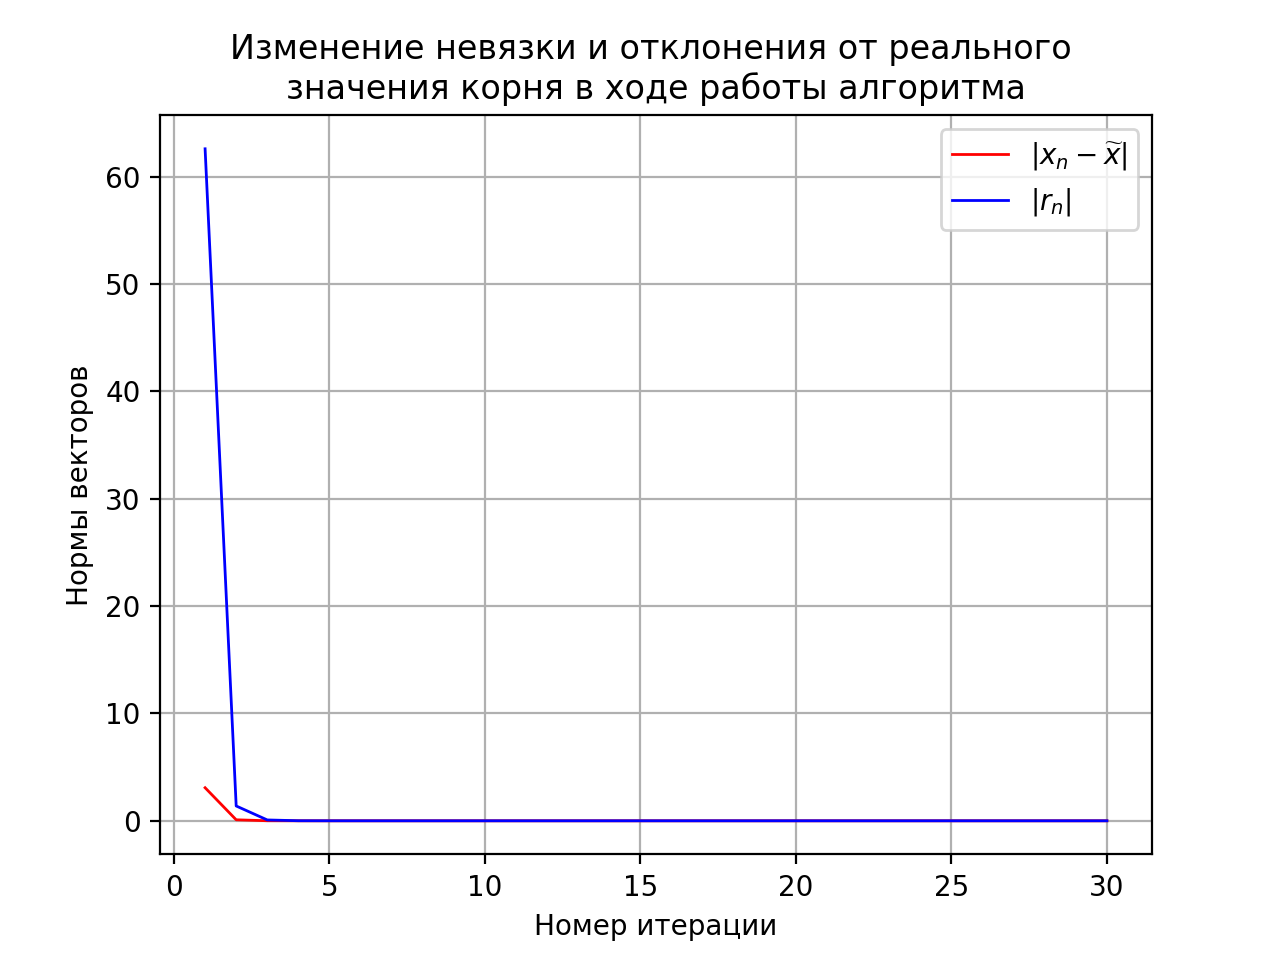

<IPython.core.display.Javascript object>


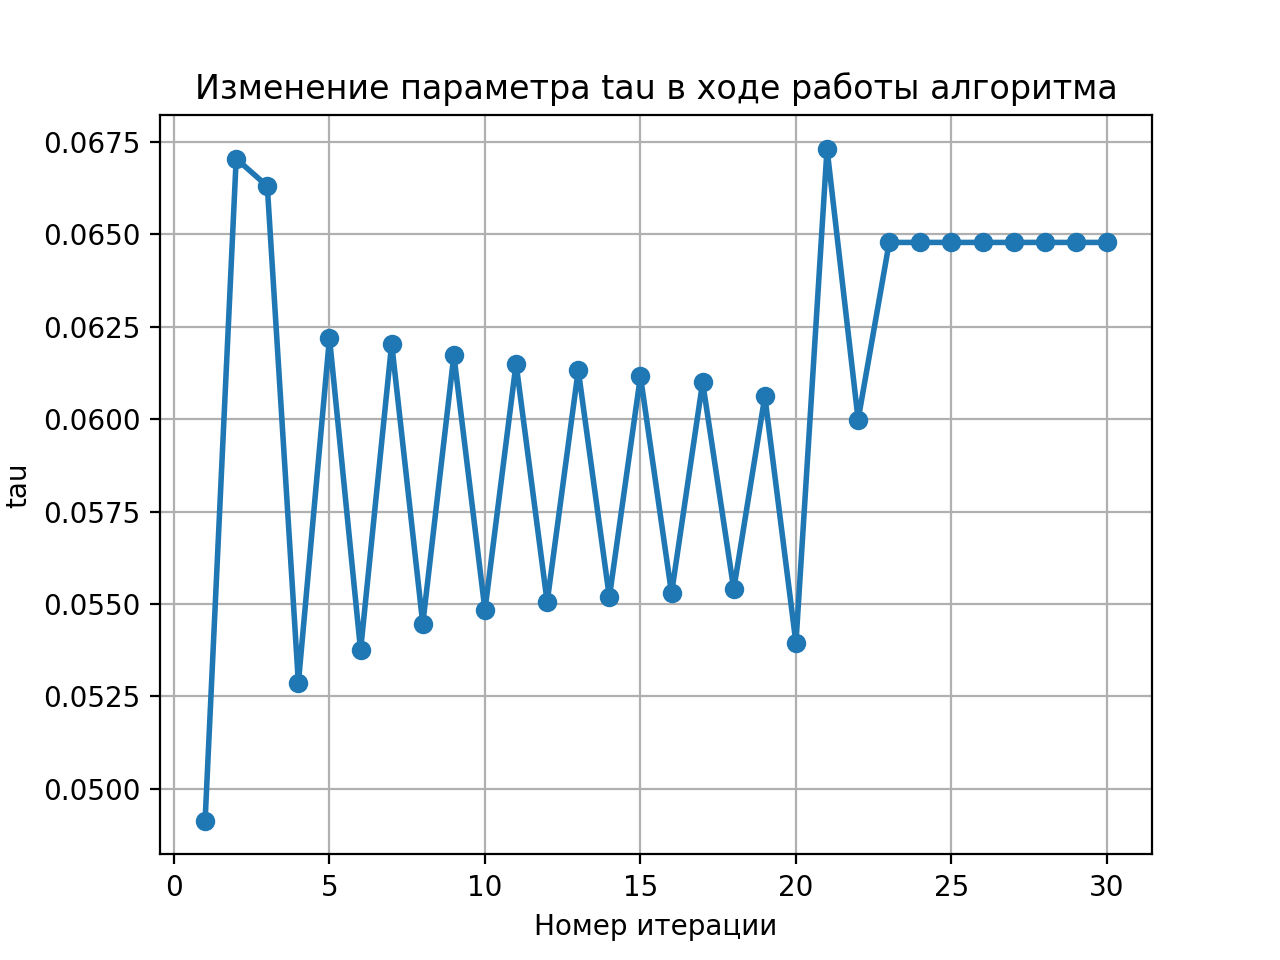

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.55111512e-17]


In [23]:
n7 = 10
A7 = rndm.uniform(size=(n7, n7)) + np.diagflat([15]*n7)
b7 = rndm.uniform(size=n7)

x7 = min_res(A7, b7, 30)

print(A7 @ x7 - b7) 

И на обычной матрице

<IPython.core.display.Javascript object>


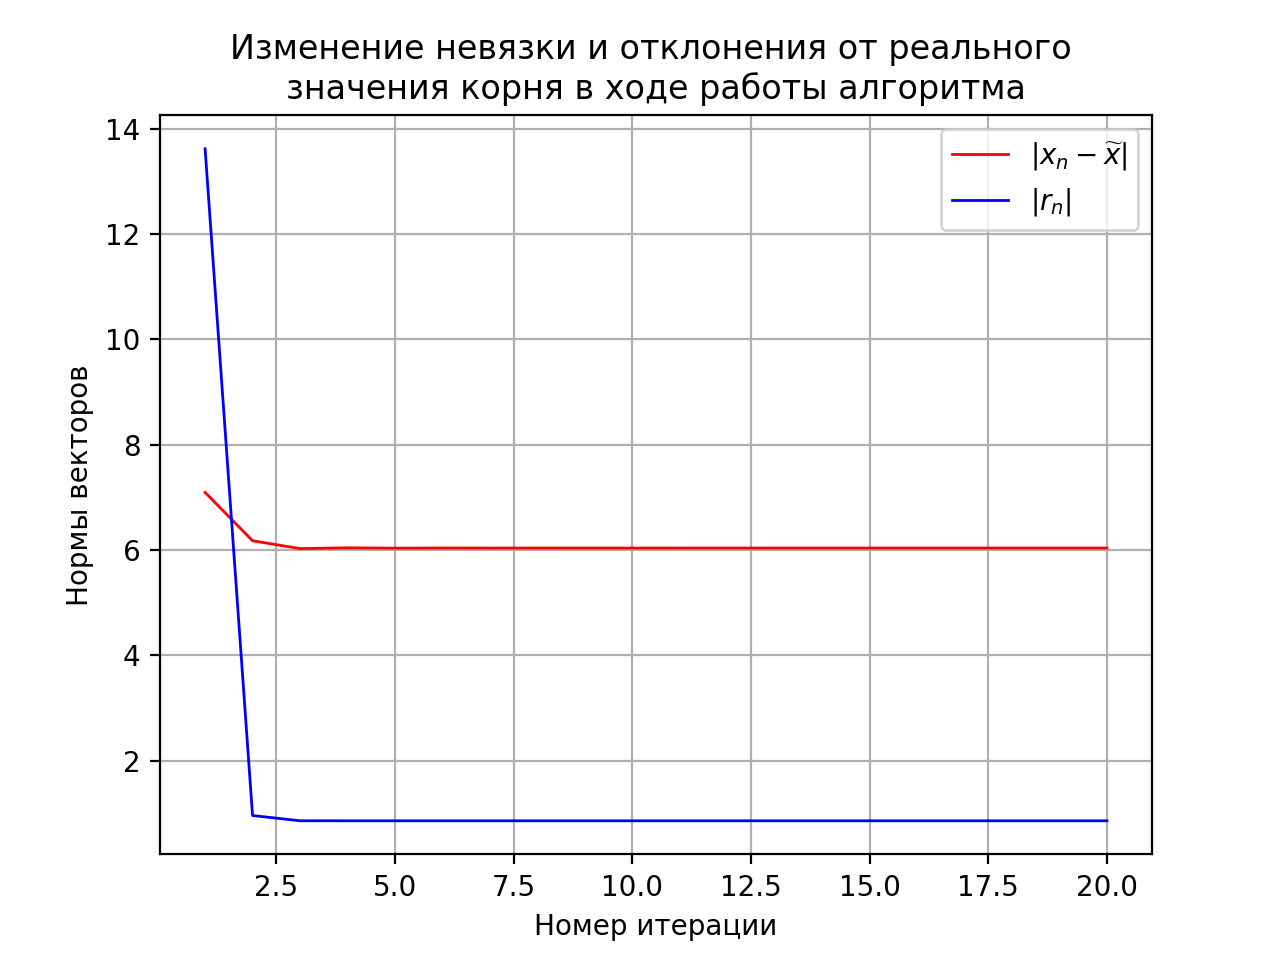

<IPython.core.display.Javascript object>


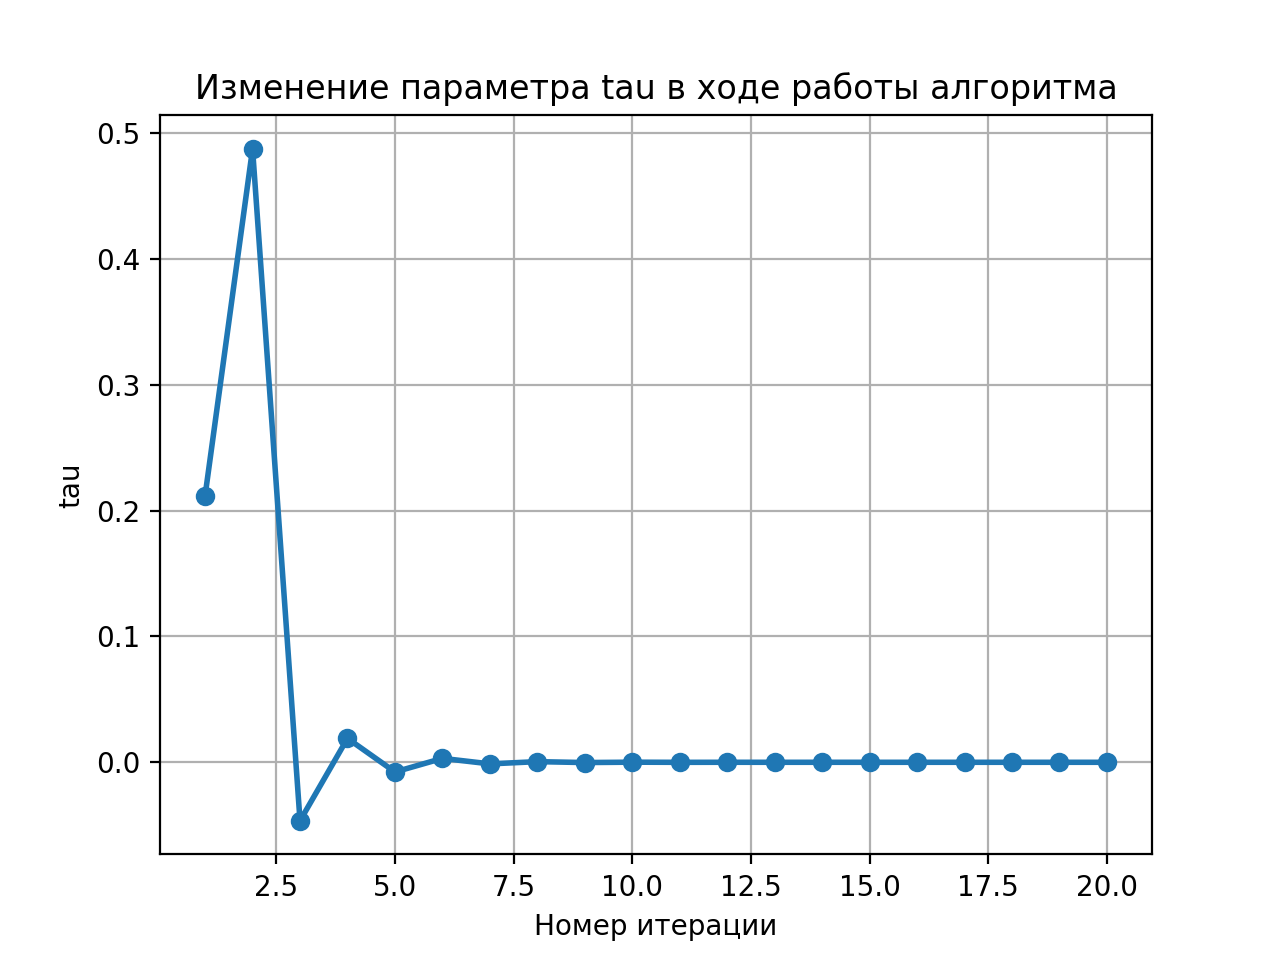

[-0.09965457  0.43154091  0.23177138 -0.024365   -0.31336884 -0.06476364
 -0.10317948  0.06422454  0.20764831 -0.56911356]


In [24]:
n8 = 10
A8 = rndm.uniform(size=(n8, n8))
b8 = rndm.uniform(size=n8)

x8 = min_res(A8, b8, 20)

print(A8 @ x8 - b8)

Как видно, в этом случае алгоритм не сходится